与往常一样，此示例中的代码将使用tf.kerasAPI，您可以在TensorFlow Keras指南中了解更多信息。

在前面的两个示例（对电影评论进行分类和预测燃油效率）中，我们看到了在验证数据上的模型的准确性在经过多个时期的训练后将达到峰值，然后开始下降。

换句话说，我们的模型将过度拟合训练数据。学习如何应对过度拟合很重要。尽管通常可以在训练集上达到高精度，但我们真正想要的是开发能够很好地推广到测试集（或之前未见的数据）的模型。

过度拟合的反面是欠拟合。当测试数据仍有改进空间时，就会发生欠拟合。发生这种情况的原因有很多：如果模型不够强大，模型过于规范化，或者仅仅是没有经过足够长时间的训练。这意味着网络尚未学习训练数据中的相关模式。

但是，如果训练时间过长，则模型将开始过拟合并从训练数据中学习无法推广到测试数据的模式。我们需要保持平衡。如下所述，了解如何训练适当的时期是一项有用的技能。

为了防止过度拟合，最好的解决方案是使用更多的训练数据。经过更多数据训练的模型自然会更好地推广。当这不再可能时，下一个最佳解决方案是使用正则化之类的技术。这些因素限制了模型可以存储的信息的数量和类型。如果一个网络只能存储少量模式，那么优化过程将迫使它专注于最突出的模式，这些模式有更好的概括机会。

在本笔记本中，我们将探讨两种常见的正则化技术（权重正则化和辍学），并使用它们来改进我们的IMDB电影评论分类笔记本。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


下载数据集

而不是像以前的笔记本中那样使用嵌入，这里我们将对句子进行多次热编码。该模型将很快适合训练集。它将用于演示何时发生过度拟合以及如何应对。

对列表进行多次热编码意味着将它们变成0和1的向量。具体而言，这意味着例如将序列 [3, 5]转换为一个10,000维向量，该向量将为全零，但索引3和5除外。

In [2]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

In [3]:
def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

让我们看一下产生的多重热矢量之一。单词索引按频率排序，因此可以预期在索引零附近有更多的1值，如我们在该图中所看到的：

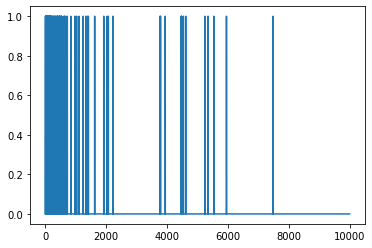

In [4]:
plt.plot(train_data[0])

In [6]:
# (batch,length)
train_data.shape

(25000, 10000)

证明过度拟合

防止过度拟合的最简单方法是减小模型的大小，即模型中可学习的参数的数量（由层数和每层单元数确定）。在深度学习中，模型中可学习参数的数量通常称为模型的“容量”。直观地讲，具有更多参数的模型将具有更多的“记忆能力”，因此将能够轻松学习训练样本与其目标之间的完美的字典式映射，这种映射没有任何泛化能力，但是在进行预测时这将是无用的根据以前看不见的数据。

始终牢记这一点：深度学习模型往往擅长拟合训练数据，但真正的挑战是泛化而不是拟合。

另一方面，如果网络的存储资源有限，则将无法轻松地学习映射。为了最大程度地减少损失，它必须学习具有更强预测能力的压缩表示形式。同时，如果您使模型过小，将难以拟合训练数据。“容量过多”和“容量不足”之间存在平衡。

不幸的是，没有神奇的公式来确定模型的正确大小或体系结构（根据层数或每层的正确大小）。您将不得不尝试使用一系列不同的体系结构。

为了找到合适的模型大小，最好从相对较少的图层和参数开始，然后开始增加图层的大小或添加新的图层，直到看到验证损失的收益递减为止。让我们在电影评论分类网络上尝试一下。

我们将仅使用Dense图层作为基准来创建一个简单的模型，然后创建越来越大的版本并进行比较。

In [7]:
# 基准模型
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [8]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.4926 - accuracy: 0.8006 - binary_crossentropy: 0.4926 - val_loss: 0.3374 - val_accuracy: 0.8760 - val_binary_crossentropy: 0.3374
Epoch 2/20
25000/25000 - 3s - loss: 0.2515 - accuracy: 0.9092 - binary_crossentropy: 0.2515 - val_loss: 0.2891 - val_accuracy: 0.8843 - val_binary_crossentropy: 0.2891
Epoch 3/20
25000/25000 - 3s - loss: 0.1851 - accuracy: 0.9340 - binary_crossentropy: 0.1851 - val_loss: 0.2869 - val_accuracy: 0.8862 - val_binary_crossentropy: 0.2869
Epoch 4/20
25000/25000 - 3s - loss: 0.1488 - accuracy: 0.9489 - binary_crossentropy: 0.1488 - val_loss: 0.3059 - val_accuracy: 0.8812 - val_binary_crossentropy: 0.3059
Epoch 5/20
25000/25000 - 3s - loss: 0.1236 - accuracy: 0.9599 - binary_crossentropy: 0.1236 - val_loss: 0.3373 - val_accuracy: 0.8756 - val_binary_crossentropy: 0.3373
Epoch 6/20
25000/25000 - 3s - loss: 0.1043 - accuracy: 0.9669 - binary_crossentropy: 0.1043 - val_loss: 0.3657

In [6]:
# 缩小参数
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [7]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.5807 - accuracy: 0.7446 - binary_crossentropy: 0.5807 - val_loss: 0.4781 - val_accuracy: 0.8385 - val_binary_crossentropy: 0.4781
Epoch 2/20
25000/25000 - 2s - loss: 0.3812 - accuracy: 0.8844 - binary_crossentropy: 0.3812 - val_loss: 0.3552 - val_accuracy: 0.8768 - val_binary_crossentropy: 0.3552
Epoch 3/20
25000/25000 - 2s - loss: 0.2814 - accuracy: 0.9094 - binary_crossentropy: 0.2814 - val_loss: 0.3084 - val_accuracy: 0.8848 - val_binary_crossentropy: 0.3084
Epoch 4/20
25000/25000 - 2s - loss: 0.2308 - accuracy: 0.9243 - binary_crossentropy: 0.2308 - val_loss: 0.2929 - val_accuracy: 0.8855 - val_binary_crossentropy: 0.2929
Epoch 5/20
25000/25000 - 2s - loss: 0.1982 - accuracy: 0.9354 - binary_crossentropy: 0.1982 - val_loss: 0.2842 - val_accuracy: 0.8875 - val_binary_crossentropy: 0.2842
Epoch 6/20
25000/25000 - 2s - loss: 0.1749 - accuracy: 0.9434 - binary_crossentropy: 0.1749 - val_loss: 0.2850

In [8]:
# 更大的模型
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [9]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.3548 - accuracy: 0.8507 - binary_crossentropy: 0.3548 - val_loss: 0.2882 - val_accuracy: 0.8832 - val_binary_crossentropy: 0.2882
Epoch 2/20
25000/25000 - 2s - loss: 0.1403 - accuracy: 0.9492 - binary_crossentropy: 0.1403 - val_loss: 0.3289 - val_accuracy: 0.8750 - val_binary_crossentropy: 0.3289
Epoch 3/20
25000/25000 - 2s - loss: 0.0481 - accuracy: 0.9868 - binary_crossentropy: 0.0481 - val_loss: 0.4311 - val_accuracy: 0.8699 - val_binary_crossentropy: 0.4311
Epoch 4/20
25000/25000 - 2s - loss: 0.0071 - accuracy: 0.9989 - binary_crossentropy: 0.0071 - val_loss: 0.5541 - val_accuracy: 0.8700 - val_binary_crossentropy: 0.5541
Epoch 5/20
25000/25000 - 2s - loss: 0.0014 - accuracy: 0.9999 - binary_crossentropy: 0.0014 - val_loss: 0.6470 - val_accuracy: 0.8696 - val_binary_crossentropy: 0.6470
Epoch 6/20
25000/25000 - 2s - loss: 5.4771e-04 - accuracy: 1.0000 - binary_crossentropy: 5.4771e-04 - val_loss

In [9]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

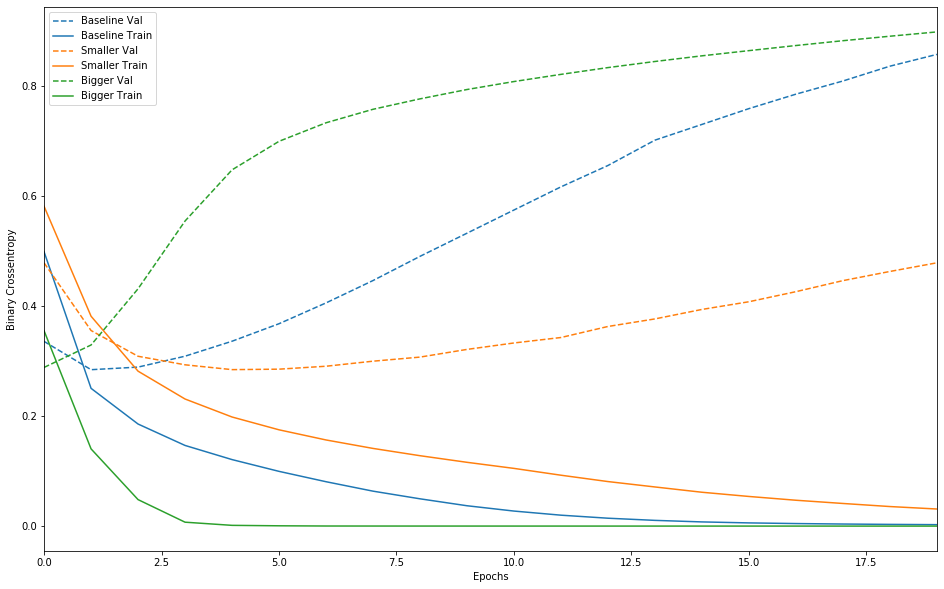

In [10]:

plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

绘制训练和验证损失

实线表示训练损失，而虚线表示验证损失（请记住：验证损失越小表示模型越好）。在这里，较小的网络比基准模型开始过度拟合（在6个时期而不是4个周期之后），并且一旦开始过度拟合，其性能下降的速度就会慢得多。

请注意，较大的网络仅在一个时期后就开始过度拟合，而严重拟合过度。网络的容量越多，将能够更快地对训练数据进行建模（导致较低的训练损失），但网络越容易适应过度（导致训练和验证损失之间存在较大差异）。

防止过度拟合的策略

* L1正则化，其中增加的成本与权重系数的绝对值成正比（即，权重的所谓“ L1范数”）。

* L2正则化，其中增加的成本与权重系数的值的平方成正比（即，权重的平方的“ L2范数”的平方）。L2正则化在神经网络中也称为权重衰减。不要让其他名称使您感到困惑：权重衰减在数学上与L2正则化完全相同。

L1正则化引入稀疏性，以使您的某些权重参数为零。L2正则化将惩罚权重参数而不使其稀疏，这是L2更为常见的原因之一

l2(0.001)意味着该层权重矩阵中的每个系数都会增加0.001 * weight_coefficient_value**2网络的总损耗。请注意，由于此惩罚仅在训练时增加，因此在训练时此网络的损失将比在测试时高得多。

In [11]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.5074 - accuracy: 0.8188 - binary_crossentropy: 0.4661 - val_loss: 0.3692 - val_accuracy: 0.8786 - val_binary_crossentropy: 0.3253
Epoch 2/20
25000/25000 - 2s - loss: 0.2967 - accuracy: 0.9091 - binary_crossentropy: 0.2482 - val_loss: 0.3362 - val_accuracy: 0.8874 - val_binary_crossentropy: 0.2846
Epoch 3/20
25000/25000 - 2s - loss: 0.2469 - accuracy: 0.9320 - binary_crossentropy: 0.1927 - val_loss: 0.3462 - val_accuracy: 0.8830 - val_binary_crossentropy: 0.2904
Epoch 4/20
25000/25000 - 2s - loss: 0.2239 - accuracy: 0.9429 - binary_crossentropy: 0.1665 - val_loss: 0.3588 - val_accuracy: 0.8802 - val_binary_crossentropy: 0.3002
Epoch 5/20
25000/25000 - 2s - loss: 0.2113 - accuracy: 0.9478 - binary_crossentropy: 0.1512 - val_loss: 0.3734 - val_accuracy: 0.8781 - val_binary_crossentropy: 0.3125
Epoch 6/20
25000/25000 - 2s - loss: 0.2004 - accuracy: 0.9530 - binary_crossentropy: 0.1385 - val_loss: 0.3905

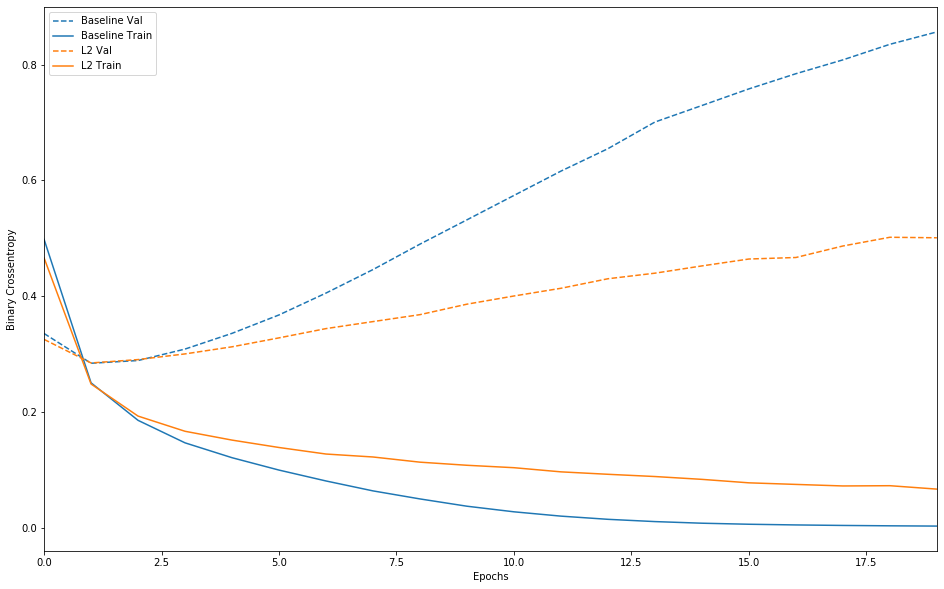

In [12]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

使用dropout

In [13]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.6419 - accuracy: 0.6298 - binary_crossentropy: 0.6419 - val_loss: 0.5144 - val_accuracy: 0.8502 - val_binary_crossentropy: 0.5144
Epoch 2/20
25000/25000 - 2s - loss: 0.4858 - accuracy: 0.7922 - binary_crossentropy: 0.4858 - val_loss: 0.3542 - val_accuracy: 0.8801 - val_binary_crossentropy: 0.3542
Epoch 3/20
25000/25000 - 2s - loss: 0.3656 - accuracy: 0.8614 - binary_crossentropy: 0.3656 - val_loss: 0.2927 - val_accuracy: 0.8870 - val_binary_crossentropy: 0.2927
Epoch 4/20
25000/25000 - 2s - loss: 0.2947 - accuracy: 0.8931 - binary_crossentropy: 0.2947 - val_loss: 0.2780 - val_accuracy: 0.8879 - val_binary_crossentropy: 0.2780
Epoch 5/20
25000/25000 - 2s - loss: 0.2467 - accuracy: 0.9138 - binary_crossentropy: 0.2467 - val_loss: 0.2805 - val_accuracy: 0.8876 - val_binary_crossentropy: 0.2805
Epoch 6/20
25000/25000 - 2s - loss: 0.2168 - accuracy: 0.9279 - binary_crossentropy: 0.2168 - val_loss: 0.2917

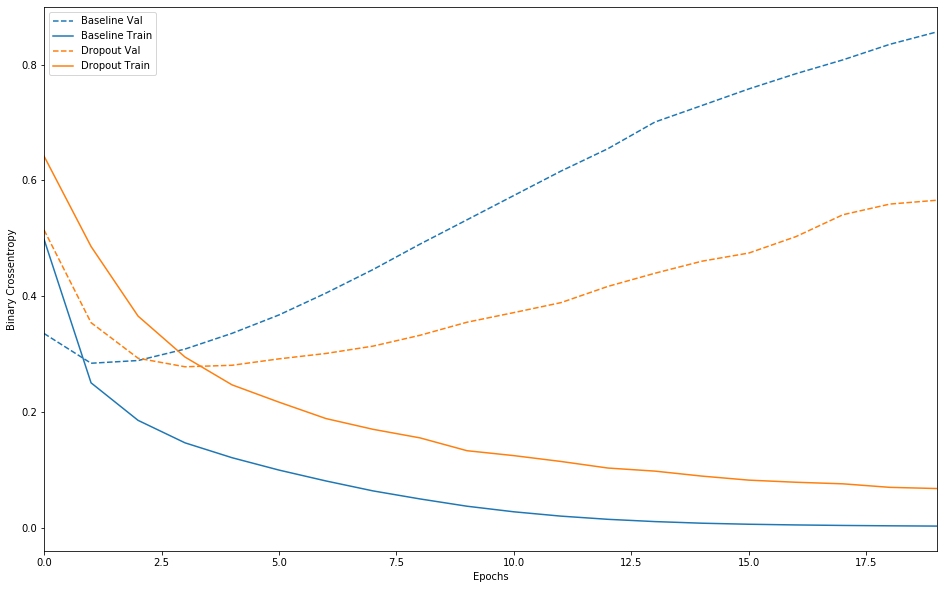

In [14]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

In [12]:
bnt_model = keras.models.Sequential([
    keras.layers.Dense(16, input_shape=(NUM_WORDS,)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(16),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1, activation='sigmoid')
])

bnt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

bnt_model_history = bnt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 4s - loss: 0.4965 - accuracy: 0.7672 - binary_crossentropy: 0.4965 - val_loss: 0.5920 - val_accuracy: 0.8568 - val_binary_crossentropy: 0.5920
Epoch 2/20
25000/25000 - 3s - loss: 0.2678 - accuracy: 0.9262 - binary_crossentropy: 0.2678 - val_loss: 0.4679 - val_accuracy: 0.8754 - val_binary_crossentropy: 0.4679
Epoch 3/20
25000/25000 - 3s - loss: 0.1747 - accuracy: 0.9608 - binary_crossentropy: 0.1747 - val_loss: 0.3805 - val_accuracy: 0.8757 - val_binary_crossentropy: 0.3805
Epoch 4/20
25000/25000 - 3s - loss: 0.1129 - accuracy: 0.9796 - binary_crossentropy: 0.1129 - val_loss: 0.3571 - val_accuracy: 0.8645 - val_binary_crossentropy: 0.3571
Epoch 5/20
25000/25000 - 3s - loss: 0.0730 - accuracy: 0.9893 - binary_crossentropy: 0.0730 - val_loss: 0.3569 - val_accuracy: 0.8497 - val_binary_crossentropy: 0.3569
Epoch 6/20
25000/25000 - 3s - loss: 0.0483 - accuracy: 0.9946 - binary_crossentropy: 0.0483 - val_loss: 0.3372

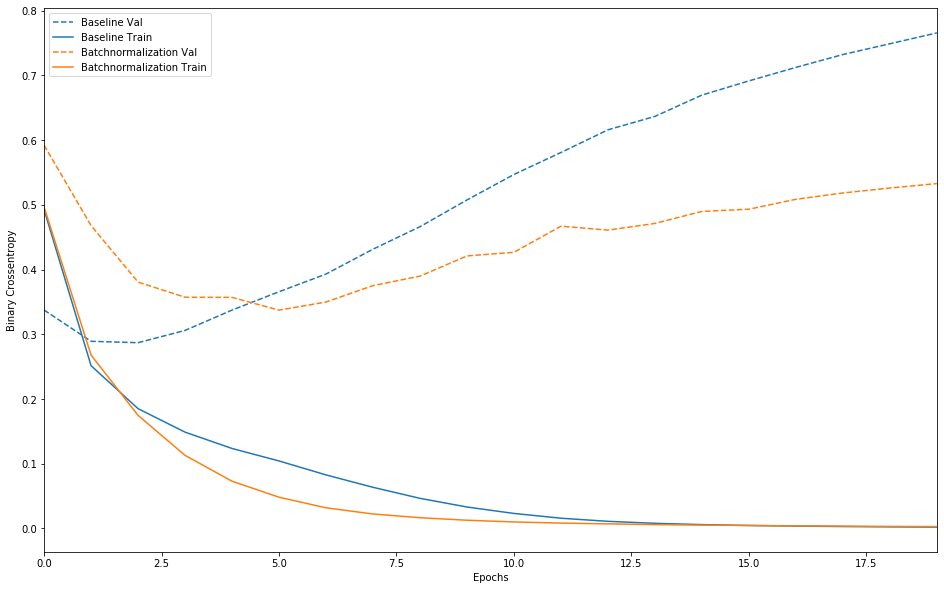

In [14]:
plot_history([('baseline', baseline_history),
              ('batchnormalization', bnt_model_history)])

以下是防止神经网络过度拟合的最常用方法：

* 获取更多培训数据。
* 减少网络容量。
* 添加体重调整。
* 添加辍学。

本指南未涵盖的两个重要方法是数据增强和批处理规范化